# Storing idx formatted images on disk as PNG and HDF5 file formats

## Comparison between storing the images using PNG vs using HDF5 

### Load into numpy arrays 

In [1]:
import idx2numpy as idx2np #to read the idx files
import numpy as np
import glob
import timeit
import os
import png
import csv
import h5py
import matplotlib.pyplot as plt

In [2]:
train_files    = [file for file in glob.glob('MNIST_idx/train-*')] #first elem is train images path and second elem is train labels path
test_files     = [file for file in glob.glob('MNIST_idc/t10k-*')] #first elem is test images path and second elem is test labels path
png_savePath   = 'MNIST_png/'
hdf5_savePath  = 'MNIST_hdf5/'

In [3]:
#MEMORY EXTENSIVE!
#both line loads the image and labels as np arrays into the memory
load_training_images = idx2np.convert_from_file(train_files[0])
load_training_labels = idx2np.convert_from_file(train_files[1])
total_images         = load_training_images.shape[0] #get the total number of images

### PNG and HDF5 comparison

In [4]:
RUN_PNG  = True
RUN_HDF5 = True

#chunks of image sizes to be tested
test_imageSize = [total_images//5, 2*(total_images//5), 3*(total_images//5), 4*(total_images//5), total_images] 
timeit_number = 50

#### PNG 

In [5]:
if RUN_PNG:
    #creates the directory if it does not exist yet
    try:
        os.mkdir(png_savePath)
        print("Directory created successfully!")
    except FileExistsError:
        print("Directory already exists")

Directory created successfully!


In [6]:
def save_file_png(arr, path, filename):
    '''Stores a single numpy array as a png file on disk
       Parameters
       -----------
       arr       : image numpy array                          | numpy array     
       path      : path to the disk to write the image file   | string
       filename  : name of the file to be saved               | string
    '''
    png.from_array(arr, mode='L').save(path+filename)

In [7]:
def labels_csv(path, filename, label):
    '''Saves the path of an image and the corresponding label as a csv file
       Parameters
       ----------
       path      : path of the image file | string
       filename  : name of the file       | string
       label     : label of the image     | integer
    '''
    #creates a csv file and write the head if the file does not exist yet.
    
    if not os.path.isfile(path + 'info.csv'): #returns False if the file does not exist
        
         with open(path + 'info.csv', 'a') as csvFile:
            
            writer = csv.writer(csvFile)
            row_head = ['File_path', 'Label'] #head
            writer.writerow(row_head)

    data_row = [path + filename, str(label)] #row to append
    
    with open(path + 'info.csv', 'a') as csvFile: #open the csv file in append mode
        
        writer = csv.writer(csvFile) 
        writer.writerow(data_row)  

In [8]:
def PNG_write(file_number):
    '''Write 'file_number' files to png on disk
       Parameter 
       --------
       file_number : number of files to be written | integer
    '''
    for counter in range(file_number):
    
        filename  = str(counter) 
        arr       = load_training_images[counter]
        label     = load_training_labels[counter]
        path      = png_savePath

        save_file_png(arr=arr, path=path, filename=filename) #write the image array as png to disk
        labels_csv(label=label, filename=filename, path=path) #write the label array to csv on disk

In [9]:
time_png = []

if RUN_PNG:
    
    for x in test_imageSize:
        #append the execution time values into the list
        time_png.append(timeit.timeit("PNG_write(file_num)", setup="file_num=int(x)", number=timeit_number, globals=globals())/timeit_number)

#### HDF5
HDF5, Hierarchical Data Format, consists of two types of objects.

**1) Datasets ; 2) Groups**


Datasets are multidimensional arrays and group consists of datasets **OR** other groups. Within a dataset, the dimensions and the type of the array have to be uniform.

In [10]:
if RUN_HDF5:
    #creates the directory if it does not exist yet
    try:
        os.mkdir(hdf5_savePath)
        print("Directory created successfully!")
    except FileExistsError:
        print("Directory already exists")

Directory created successfully!


In saving the images as .png to the disk, a function that is created to store a single file can be repeated until all the images are stored. However, in HDF5, we can store them all at once.

In [11]:
def many_hdf5(file_num):
    '''Store multiple images to HDF5.
       Parameters
       ----------
       file_num : number of files to be written | integer
    '''
    images = load_training_images[:file_num]
    labels = load_training_labels[:file_num]
    
    file = h5py.File(hdf5_savePath + str(file_num) + '.h5', 'w') #open an hdf5 file
    
    dataset_1 = file.create_dataset("images", np.shape(images), h5py.h5t.STD_U8BE, data=images) 
    dataset_2 = file.create_dataset("meta", np.shape(labels), h5py.h5t.STD_U8BE, data=labels)
    
    file.close()

In [12]:
time_hdf5 = []

if RUN_HDF5:

    for x in test_imageSize:
        #append the execution time values into the list
        time_hdf5.append(timeit.timeit("many_hdf5(file_num)", setup="file_num=int(x)", number=timeit_number, globals=globals())/timeit_number)

### Comparison Graph

In [13]:
x_axis      = test_imageSize
y_axis_png  = time_png
y_axis_hdf5 = time_hdf5

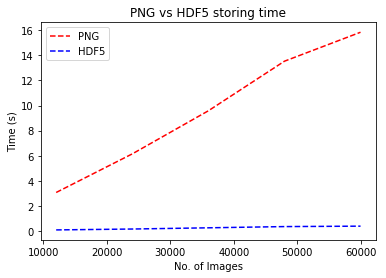

In [14]:
#Graph plotting
plt.plot(x_axis, y_axis_png, 'r--', label='PNG')
plt.plot(x_axis, y_axis_hdf5, 'g--', label='HDF5')
plt.title("PNG vs HDF5 storing time")
plt.ylabel("Time (s)")
plt.xlabel("No. of Images")
plt.legend()
plt.show()